In [1]:
import os
import sys
import random
import math
import re
import time
from PIL import Image
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework import meta_graph
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

from samples.hand import hand

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

WEIGHTS_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_hand.h5")

MODEL_PATH = os.path.join(ROOT_DIR, "weights/model/model")

OUTPUT_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_hand")

# Configurations of the model
class InferenceConfig(hand.HandConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BATCH_SIZE = 1
    DETECTION_MIN_CONFIDENCE = 0.9
    POST_NMS_ROIS_INFERENCE = 100

config = InferenceConfig()

BATCH_SIZE = 1

IMAGE_RESIZE_MODE = config.IMAGE_RESIZE_MODE
IMAGE_MIN_DIM = config.IMAGE_MIN_DIM
IMAGE_MAX_DIM = config.IMAGE_MAX_DIM
IMAGE_MIN_SCALE = config.IMAGE_MIN_SCALE
MEAN_PIXEL = config.MEAN_PIXEL
CLASS_IDS = np.zeros([config.NUM_CLASSES], dtype=np.int32)
IMAGE_SHAPE = config.IMAGE_SHAPE
BACKBONE = config.BACKBONE
BACKBONE_STRIDES = config.BACKBONE_STRIDES
RPN_ANCHOR_SCALES = config.RPN_ANCHOR_SCALES
RPN_ANCHOR_RATIOS = config.RPN_ANCHOR_RATIOS
RPN_ANCHOR_STRIDE = config.RPN_ANCHOR_STRIDE

INPUT_NODE_IMAGE_NAME = "input_image"
INPUT_NODE_IMAGE_METADATA_NAME = "input_image_meta"
INPUT_NODE_ANCHORS_NAME = "input_anchors"
OUTPUT_NODE_NAMES = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois", "rpn_class", "rpn_bbox"]

float_type = tf.float32
int_type = tf.int32

def get_tensor(graph, name, suffix=":0"):
    return graph.get_tensor_by_name(f"{name}{suffix}")

Using TensorFlow backend.


In [2]:
original_image = np.array(Image.open(os.path.join(ROOT_DIR, 'images/hand.png')))
original_image.shape

(240, 320, 3)

# Pre Processing

In [3]:
def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """

    h = tf.cast(shape[0], dtype=float_type)
    w = tf.cast(shape[1], dtype=float_type)

    scale = tf.stack([h - 1, w - 1, h - 1, w - 1], axis=0)
    shift = tf.constant([0, 0, 1, 1], dtype=float_type)
    return tf.divide((boxes - shift), scale)

def resize_image(image, min_dim, max_dim):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    
    scale = tf.maximum(tf.constant(1, dtype=float_type), tf.cast(min_dim / tf.minimum(h, w), dtype=float_type))

    image_max = tf.maximum(h, w)
    scale = tf.cond(tf.cast(tf.round(tf.cast(image_max, dtype=float_type) * scale), dtype=int_type) > max_dim,
                    lambda: tf.cast(max_dim / image_max, dtype=float_type),
                    lambda: scale)
    
    # Warning: only mode "square" is supported here.
    # Resize image using bilinear interpolation.
    image = tf.image.resize_images(image, 
                                   (tf.cast(tf.round(tf.cast(h, dtype=float_type) * scale), dtype=int_type), 
                                    tf.cast(tf.round(tf.cast(w, dtype=float_type) * scale), dtype=int_type)))

    # Mode == "square"
    new_h = tf.shape(image)[0]
    new_w = tf.shape(image)[1]
    top_pad = (max_dim - new_h) // 2
    bottom_pad = max_dim - new_h - top_pad
    left_pad = (max_dim - new_w) // 2
    right_pad = max_dim - new_w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = tf.pad(image, padding, mode='constant', constant_values=0)
    window = (top_pad, left_pad, new_h + top_pad, new_w + left_pad)
    
    return image, window, scale, padding

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = tf.concat([tf.cast([image_id], dtype=float_type),
                      tf.cast(tf.map_fn(lambda x: x, original_image_shape), dtype=float_type),
                      tf.cast(tf.map_fn(lambda x: x, image_shape), dtype=float_type),
                      tf.cast(window, dtype=float_type),
                      tf.cast([scale], dtype=float_type),
                      tf.cast(class_ids, dtype=float_type)], axis=0)
    
    return meta

def mold_inputs(image, min_dim, max_dim, mean_pixels, class_ids):
    """Takes a list of images and modifies them to the format expected
    as an input to the neural network.
    images: List of image matrices [height,width,depth]. Images can have
        different sizes.

    Returns 3 Numpy matrices:
    molded_images: [N, h, w, 3]. Images resized and normalized.
    image_metas: [N, length of meta data]. Details about each image.
    windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
        original image (padding excluded).
    """
    molded_image, window, scale, padding = resize_image(image, min_dim, max_dim)
    
    molded_image = mold_image(molded_image, mean_pixels)
    
    image_meta = compose_image_meta(tf.constant(0), tf.shape(image), tf.shape(molded_image),
                       window, scale, class_ids)
    
    return molded_image, image_meta, window

def mold_image(image, mean_pixels):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return tf.subtract(image, mean_pixels)

def get_anchors(image_shape, scales, ratios, feature_strides, anchor_stride):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(image_shape, feature_strides)
    
    anchors = generate_pyramid_anchors(scales, ratios, backbone_shapes, feature_strides, anchor_stride)
    
    anchors = norm_boxes(anchors, image_shape[:2])
    
    return anchors

def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides, anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    n_anchors_per_scale = feature_shapes[:, 0] * feature_shapes[:, 1] * tf.shape(ratios)[0]
    n_anchors = tf.reduce_sum(n_anchors_per_scale, axis=0)
    
    maximum_row_per_scale = tf.reduce_max(n_anchors_per_scale)
    improbable_value = 100.7893878475

    num_elems = tf.shape(scales)[0]
    init_array = tf.TensorArray(dtype=float_type, size=num_elems)
    initial_i = tf.constant(0, dtype=int_type)

    def loop_body(i, ta):
        scale = scales[i]
        shape = feature_shapes[i]
        feature_stride = feature_strides[i]
        
        anchor = generate_anchors(scale, ratios, shape, feature_stride, anchor_stride)

        anchor = tf.cast(anchor, dtype=float_type)
        anchor = tf.pad(anchor, [[0, maximum_row_per_scale - tf.shape(anchor)[0]], [0, 0]],
                        constant_values=improbable_value)
        ta = ta.write(i, anchor)
        return i+1, ta

    _, anchors = tf.while_loop(lambda i, ta: i < num_elems, loop_body, [initial_i, init_array])

    anchors = anchors.stack()
    anchors = tf.reshape(anchors, shape=(-1, 4))

    # Here is an extremly ugly hack that consist of padding all the missing rows inside the tf.while_loop
    # with a very improbable value for then remove all the rows containing that value. That way, inside the tf.while_loop
    # all returned tensors are of the same shape. See
    # https://stackoverflow.com/questions/50087883/tf-while-loop-with-flexible-row-numbers-per-iteration for details.
    anchors = tf.boolean_mask(anchors, tf.not_equal(tf.reduce_sum(anchors, axis=1), improbable_value * 4), axis=0)
    
    return anchors

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = tf.meshgrid(tf.cast(scales, dtype=float_type), ratios)
    scales = tf.reshape(scales, [-1])
    ratios = tf.reshape(ratios, [-1])

    # Enumerate heights and widths from scales and ratios
    heights = scales / tf.sqrt(ratios)
    widths = scales * tf.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = tf.cast(tf.range(0, shape[0], anchor_stride) * feature_stride, dtype=float_type)
    shifts_x = tf.cast(tf.range(0, shape[1], anchor_stride) * feature_stride, dtype=float_type)
    shifts_x, shifts_y = tf.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = tf.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = tf.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = tf.reshape(tf.stack([box_centers_y, box_centers_x], axis=2), [-1, 2])
    box_sizes = tf.reshape(tf.stack([box_heights, box_widths], axis=2), [-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = tf.concat([box_centers - 0.5 * box_sizes,
                       box_centers + 0.5 * box_sizes], axis=1)
    return boxes

def compute_backbone_shapes(image_shape, backbone_strides):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    backbone_shape_y = tf.map_fn(lambda stride: tf.cast(tf.round(tf.ceil(image_shape[0] / stride)), dtype=int_type),
                             backbone_strides)
    backbone_shape_x = tf.map_fn(lambda stride: tf.cast(tf.round(tf.ceil(image_shape[1] / stride)), dtype=int_type),
                                 backbone_strides)
    backbone_shapes = tf.stack([backbone_shape_y, backbone_shape_x])
    backbone_shapes = tf.transpose(backbone_shapes)
    
    return backbone_shapes

In [4]:
preprocessing_graph = tf.Graph()

with preprocessing_graph.as_default():
    # Define the inputs
    image = tf.placeholder(dtype=int_type, shape=(None, None, 3), name="input_image")

    min_dim = tf.constant(IMAGE_MIN_DIM, dtype=int_type)
    max_dim = tf.constant(IMAGE_MAX_DIM, dtype=int_type)
    mean_pixels = tf.constant(MEAN_PIXEL, dtype=float_type)
    class_ids = tf.constant(CLASS_IDS, dtype=int_type)
    backbone_strides = tf.constant(BACKBONE_STRIDES, dtype=int_type)
    rpn_anchor_scales = tf.constant(RPN_ANCHOR_SCALES, dtype=int_type)
    rpn_anchor_ratios = tf.constant(RPN_ANCHOR_RATIOS, dtype=float_type)
    rpn_anchor_stride = tf.constant(RPN_ANCHOR_STRIDE, dtype=int_type)

    molded_image, image_meta, window = mold_inputs(image, min_dim, max_dim, mean_pixels, class_ids)

    anchors = get_anchors(tf.shape(molded_image), rpn_anchor_scales, rpn_anchor_ratios, backbone_strides, rpn_anchor_stride)
    
    molded_image = tf.expand_dims(molded_image, axis=0)
    image_meta = tf.expand_dims(image_meta, axis=0)
    anchors = tf.expand_dims(anchors, axis=0)
    
    molded_image = tf.identity(molded_image, name="molded_image")
    image_meta = tf.identity(image_meta, name="image_metadata")
    window = tf.identity(window, name="window")
    anchors = tf.identity(anchors, name="anchors")

In [5]:
with tf.Session(graph=preprocessing_graph) as sess:
    # Declare inputs
    image = get_tensor(sess.graph, "input_image")
    
    feed_dict = {image: original_image,}
    
    # Declare outputs  
    fetches = {"molded_image": get_tensor(sess.graph, "molded_image"),
               "image_metadata": get_tensor(sess.graph, "image_metadata"),
               "window": get_tensor(sess.graph, "window"),
               "anchors": get_tensor(sess.graph, "anchors")}
    
    preprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
preprocessing_results.keys()

dict_keys(['molded_image', 'image_metadata', 'window', 'anchors'])

# Mask R-CNN

In [6]:
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
    
# Load weights
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  D:\Programming\Project\Object Detection\hand_mask_rcnn\weights/mask_rcnn_hand.h5


In [7]:
# Get keras model and save
model_keras= model.keras_model
# All new operations will be in test mode from now on.
K.set_learning_phase(0)

# Create output layer with customized names
num_output = 7
pred_node_names = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois", "rpn_class", "rpn_bbox"]
pred_node_names = ["output_" + name for name in pred_node_names]
pred = [tf.identity(model_keras.outputs[i], name = pred_node_names[i])for i in range(num_output)]

sess = K.get_session()

s = tf.train.Saver()
s.save(sess, MODEL_PATH)

'D:\\Programming\\Project\\Object Detection\\hand_mask_rcnn\\weights/model/model'

In [8]:
t1 = time.time()
# Run object detection
results = model.keras_model.predict([preprocessing_results["molded_image"], 
                                     preprocessing_results["image_metadata"],
                                     preprocessing_results["anchors"]])
print('runtime: %.2f' % (time.time() - t1))

runtime: 11.41


# Post Processing

In [9]:
def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h = tf.cast(shape[0], dtype=float_type)
    w = tf.cast(shape[1], dtype=float_type)
    
    scale = tf.stack([h - 1, w - 1, h - 1, w - 1], axis=0)
    shift = tf.constant([0, 0, 1, 1], dtype=float_type)
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), dtype=int_type)

def unmold_detections(detections, mrcnn_mask, original_image_shape, image_shape, window):
    """Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the
    application.

    detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
    mrcnn_mask: [N, height, width, num_classes]
    original_image_shape: [H, W, C] Original image shape before resizing
    image_shape: [H, W, C] Shape of the image after resizing and padding
    window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
            image is excluding the padding.

    Returns:
    boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids: [N] Integer class IDs for each bounding box
    scores: [N] Float probability scores of the class_id
    masks: [height, width, num_instances] Instance masks
    """
    zero_ix = tf.where(tf.equal(detections[:, 4], 0))[0]
    N = tf.cond(tf.shape(zero_ix)[0] > 0, 
                lambda: tf.cast(zero_ix[0], dtype=int_type), 
                lambda: tf.cast(tf.shape(detections)[0], dtype=int_type))

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = tf.cast(detections[:N, 4], dtype=int_type)
    scores = detections[:N, 5]
    masks = tf.cond(N > 0,
                    lambda: tf.map_fn(lambda i: mrcnn_mask[i,:,:,class_ids[i]], tf.range(N), dtype=float_type),
                    lambda: tf.zeros((0, tf.shape(mrcnn_mask)[1], tf.shape(mrcnn_mask)[2]), dtype=float_type))

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    window = norm_boxes(window, image_shape[:2])
    wy1 = window[0]
    wx1 = window[1]
    wy2 = window[2]
    wx2 = window[3]
    shift = tf.stack([wy1, wx1, wy1, wx1], axis=0)
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = tf.stack([wh, ww, wh, ww], axis=0) 
    # Convert boxes to normalized coordinates on the window
    boxes = tf.divide(boxes - shift, scale)
    # Convert boxes to pixel coordinates on the original image
    boxes = denorm_boxes(boxes, original_image_shape[:2])

    # Resize masks to original image size and set boundary threshold.
    full_masks = tf.cond(N > 0,
                        lambda: tf.map_fn(lambda i: unmold_mask(masks[i], boxes[i], original_image_shape[:2]), tf.range(N), dtype=tf.bool),
                        lambda: tf.zeros((0, original_image_shape[0], original_image_shape[1]), dtype=tf.bool)) 
    
    return boxes, class_ids, scores, full_masks

def unmold_mask(mask, bbox, shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = tf.constant(0.5, dtype=float_type)
    
    h = tf.cast(shape[0], dtype=int_type)
    w = tf.cast(shape[1], dtype=int_type)
    
    y1 = tf.cast(bbox[0], dtype=int_type)
    x1 = tf.cast(bbox[1], dtype=int_type)
    y2 = tf.cast(bbox[2], dtype=int_type)
    x2 = tf.cast(bbox[3], dtype=int_type)
    
    mask = tf.squeeze(tf.image.resize_images(tf.expand_dims(mask, axis=-1), (y2 - y1, x2 - x1)))
    ones = tf.ones_like(mask)
    zeros = tf.zeros_like(mask)
    mask = tf.cast(tf.where(mask >= threshold, ones, zeros), dtype=tf.bool)
    
    # Put the mask in the right location.
    padding = [[y1, h - y2], [x1, w - x2]]
    full_mask = tf.pad(mask, padding)
    
    return full_mask

In [10]:
postprocessing_graph = tf.Graph()

with postprocessing_graph.as_default():

    # Define the inputs

    # [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
    detections = tf.placeholder(dtype=float_type, shape=(None, 6), name="detections")

    # [N, height, width, num_classes]
    mrcnn_mask = tf.placeholder(dtype=float_type, shape=(None, None, None, None), name="mrcnn_mask")

    # [H, W, C] Original image shape before resizing
    original_image_shape = tf.cast(tf.placeholder(dtype=int_type, shape=(3,), name="original_image_shape"), dtype=float_type)

    # [H, W, C] Shape of the image after resizing and padding
    # image_shape = tf.placeholder(dtype=float_type, shape=(3,), name="image_shape")
    image_shape = tf.constant(IMAGE_SHAPE, dtype=float_type)

    # [y1, x1, y2, x2] Pixel coordinates of box in the image where the real image is excluding the padding.
    window = tf.cast(tf.placeholder(dtype=int_type, shape=(4), name="window"), dtype=float_type)

    # Define postprocessing operations
    boxes, class_ids, scores, full_masks = unmold_detections(detections, mrcnn_mask, original_image_shape,
                                                             image_shape, window)

    boxes = tf.identity(boxes, name="rois")
    class_ids = tf.identity(class_ids, name="class_ids")
    scores = tf.identity(scores, name="scores")
    full_masks = tf.identity(full_masks, name="masks")

In [11]:
with tf.Session(graph=postprocessing_graph) as sess:
    detections = get_tensor(sess.graph, "detections")
    mrcnn_mask = get_tensor(sess.graph, "mrcnn_mask")
    original_image_shape = get_tensor(sess.graph, "original_image_shape")
    window = get_tensor(sess.graph, "window")

    feed_dict = {detections: results[0][0],
                 mrcnn_mask: results[3][0],
                 original_image_shape: list(original_image.shape),
                 window: preprocessing_results["window"]}
    
    # Declare outputs   
    fetches = {"rois": get_tensor(sess.graph, "rois"),
               "class_ids": get_tensor(sess.graph, "class_ids"),
               "scores": get_tensor(sess.graph, "scores"),
               "masks": get_tensor(sess.graph, "masks")}
    
    postprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
postprocessing_results.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

# Visualization

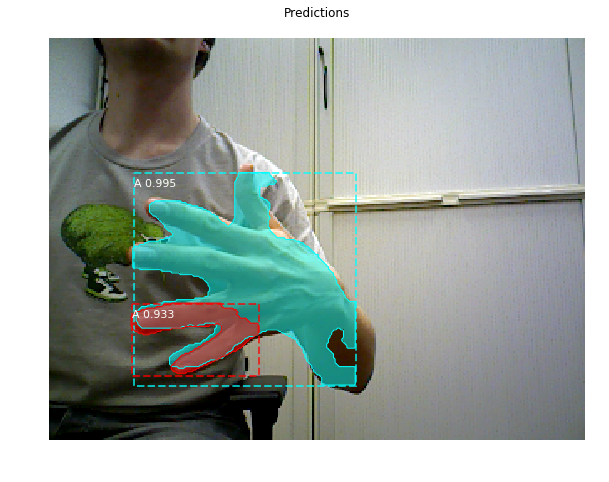

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

visualize.display_instances(original_image, postprocessing_results['rois'],
                            np.transpose(postprocessing_results['masks'], (1,2,0)), 
                            postprocessing_results['class_ids'], 
                            'HAND', postprocessing_results['scores'], ax=ax,
                            title="Predictions")

# Combine Graph

In [13]:
graph = tf.Graph()
with graph.as_default():
    meta_graph1 = tf.train.export_meta_graph(graph=preprocessing_graph)
    meta_graph.import_scoped_meta_graph(meta_graph1, import_scope="preprocessing_graph")
    
    input_image = graph.get_tensor_by_name('preprocessing_graph/input_image:0')
    molded_image = graph.get_tensor_by_name('preprocessing_graph/molded_image:0')
    image_metadata = graph.get_tensor_by_name('preprocessing_graph/image_metadata:0')
    window = graph.get_tensor_by_name('preprocessing_graph/window:0')
    anchors = graph.get_tensor_by_name('preprocessing_graph/anchors:0')
        
    saver = tf.train.import_meta_graph(MODEL_PATH + '.meta', 
                                        input_map={f'{INPUT_NODE_IMAGE_NAME}:0': molded_image, 
                                                   f'{INPUT_NODE_IMAGE_METADATA_NAME}:0': image_metadata, 
                                                   f'{INPUT_NODE_ANCHORS_NAME}:0': anchors,},
                                        import_scope="model_graph")
    
    detections = graph.get_tensor_by_name('model_graph/output_detections:0')
    mrcnn_mask = graph.get_tensor_by_name('model_graph/output_mrcnn_mask:0')
        
    meta_graph3 = tf.train.export_meta_graph(graph=postprocessing_graph)
    meta_graph.import_scoped_meta_graph(meta_graph3, 
                                        input_map={"detections:0": detections[0],
                                                   "mrcnn_mask:0": mrcnn_mask[0],
                                                   "original_image_shape:0": tf.shape(input_image),
                                                   "window:0": window,},
                                        import_scope="postprocessing_graph")

In [14]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, MODEL_PATH)
    
    inputs = {"input_image": get_tensor(sess.graph, "preprocessing_graph/input_image")}
    outputs = {"rois": get_tensor(sess.graph, "postprocessing_graph/rois"),
               "class_ids": get_tensor(sess.graph, "postprocessing_graph/class_ids"),
               "scores": get_tensor(sess.graph, "postprocessing_graph/scores"),
               "masks": get_tensor(sess.graph, "postprocessing_graph/masks")}
    
    builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_PATH)

    signature = tf.saved_model.predict_signature_def(inputs=inputs, outputs=outputs)

    builder.add_meta_graph_and_variables(sess=sess,
                                         tags=[tf.saved_model.tag_constants.SERVING],
                                         signature_def_map={'predict': signature})
    builder.save()

INFO:tensorflow:Restoring parameters from D:\Programming\Project\Object Detection\hand_mask_rcnn\weights/model/model
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: D:\Programming\Project\Object Detection\hand_mask_rcnn\weights/mask_rcnn_hand\saved_model.pb


# Check SavedModel

In [21]:
original_image = np.array(Image.open(os.path.join(ROOT_DIR, 'images/hand.png')))

hand_mask_rcnn_graph = tf.Graph()
with tf.Session(graph=hand_mask_rcnn_graph) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], OUTPUT_PATH)
    
    input_image = get_tensor(sess.graph, "preprocessing_graph/input_image")
    
    feed_dict = {input_image: original_image}
    fetch = {"rois": get_tensor(sess.graph, "postprocessing_graph/rois"),
             "class_ids": get_tensor(sess.graph, "postprocessing_graph/class_ids"),
             "scores": get_tensor(sess.graph, "postprocessing_graph/scores"),
             "masks": get_tensor(sess.graph, "postprocessing_graph/masks")}
    
    t1 = time.time()
    
    # Declare outputs  
    results = sess.run(fetch, feed_dict=feed_dict)
    
    print('runtime: %.2f' % (time.time() - t1))

INFO:tensorflow:Restoring parameters from D:\Programming\Project\Object Detection\hand_mask_rcnn\weights/mask_rcnn_hand\variables\variables
runtime: 11.63


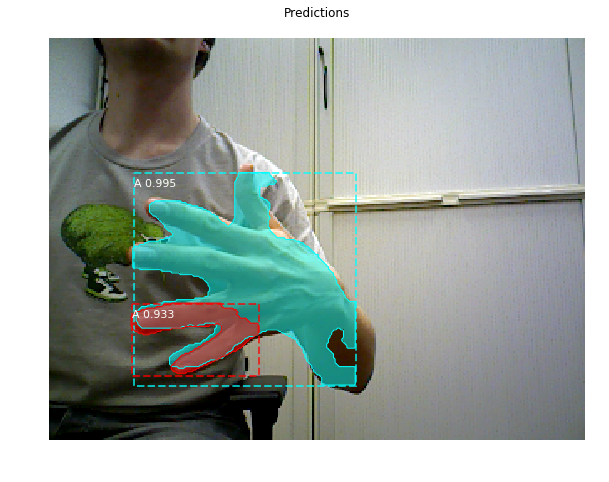

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))

visualize.display_instances(original_image, results['rois'], np.transpose(results['masks'], (1,2,0)),
                            results['class_ids'], 'HAND', results['scores'], ax=ax,
                            title="Predictions")